In [1]:
import pandas as pd
import bioframe as bf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tarfile
from natsort import natsort_keygen
import tempfile
import math
import re

In [2]:
tars = [
    "../../data/output/structural_variants/hint_cnv/hg38_MCF10A_WT_merged.tar.gz",
    "../../data/output/structural_variants/hint_cnv/hg38_MCF10A_T1_merged.tar.gz",
    "../../data/output/structural_variants/hint_cnv/hg38_MCF10A_C1_merged.tar.gz",
]

keys = ["WT", "T1", "C1"]

In [3]:
def import_segments(path: str):
    dfs = []
    with tarfile.open(path) as tar, tempfile.TemporaryDirectory() as tmpdir:
        pattern = re.compile(r"/segmentation/b\d+/.*\.bin")
        members = []
        for member in tar.getmembers():
            if pattern.search(member.name):
                members.append(member)
        tar.extractall(tmpdir, members=members)
        pattern = re.compile(r".*chrm_(.+)\.b\d+\.bin")
        for m in members:
            path = f"{tmpdir}/{m.name}"
            df = pd.read_table(path)
            df["chrom"] = "chr" + pattern.search(path).group(1).lstrip("0")
            df["end"] += 1
            df["obs"] *= 2
            df["obs"] -= 2
            dfs.append(df)

    return pd.concat(dfs)[["chrom", "start", "end", "obs"]].sort_values(["chrom", "start"], key=natsort_keygen())

In [4]:
dfs = {k: import_segments(t) for k, t in zip(keys, tars)}
dfs[keys[0]]

,chrom,start,end,obs
0,chr1,0,50000,-1.856585
1,chr1,50000,100000,-0.972481
2,chr1,100000,150000,3.235830
3,chr1,150000,200000,0.805327
4,chr1,200000,250000,-1.945709
...,...,...,...,...
3105,chrX,155800000,155850000,-1.999510
3106,chrX,155850000,155900000,-1.999861
3107,chrX,155900000,155950000,-1.999641
3108,chrX,155950000,156000000,-1.999848


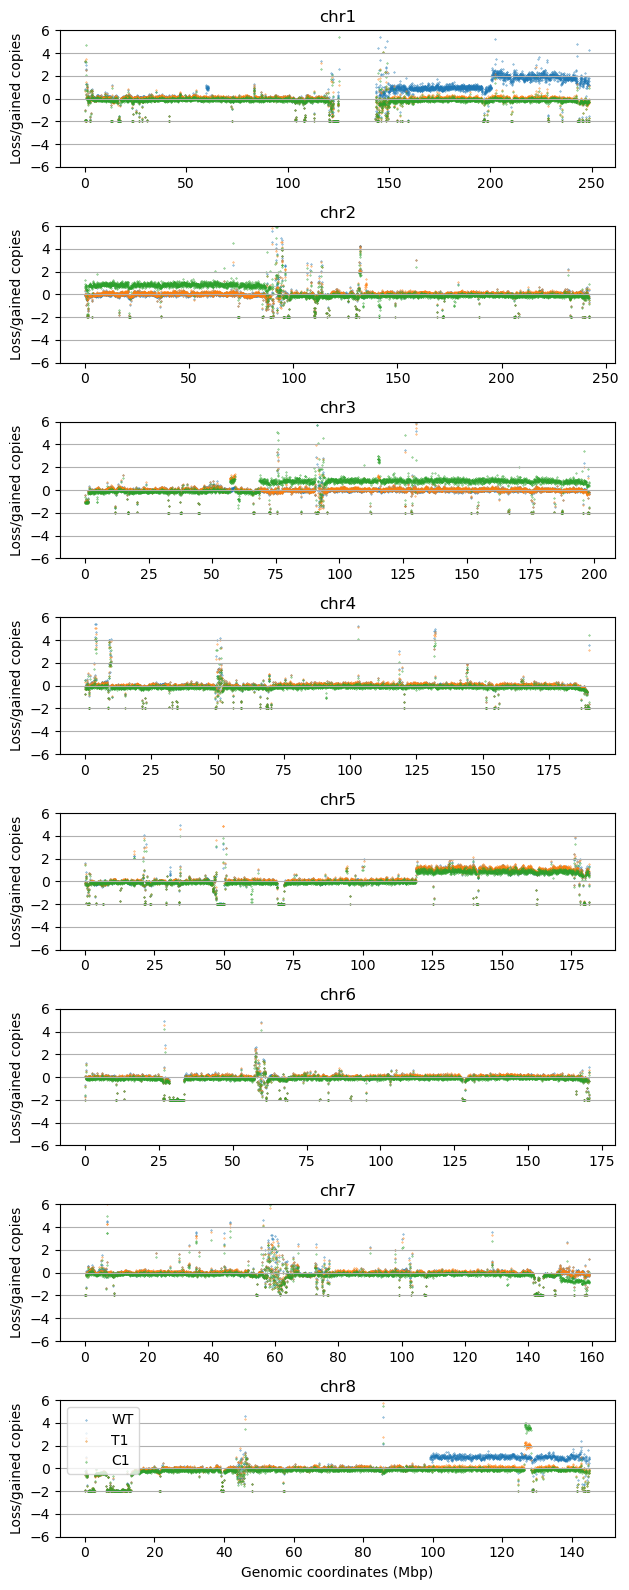

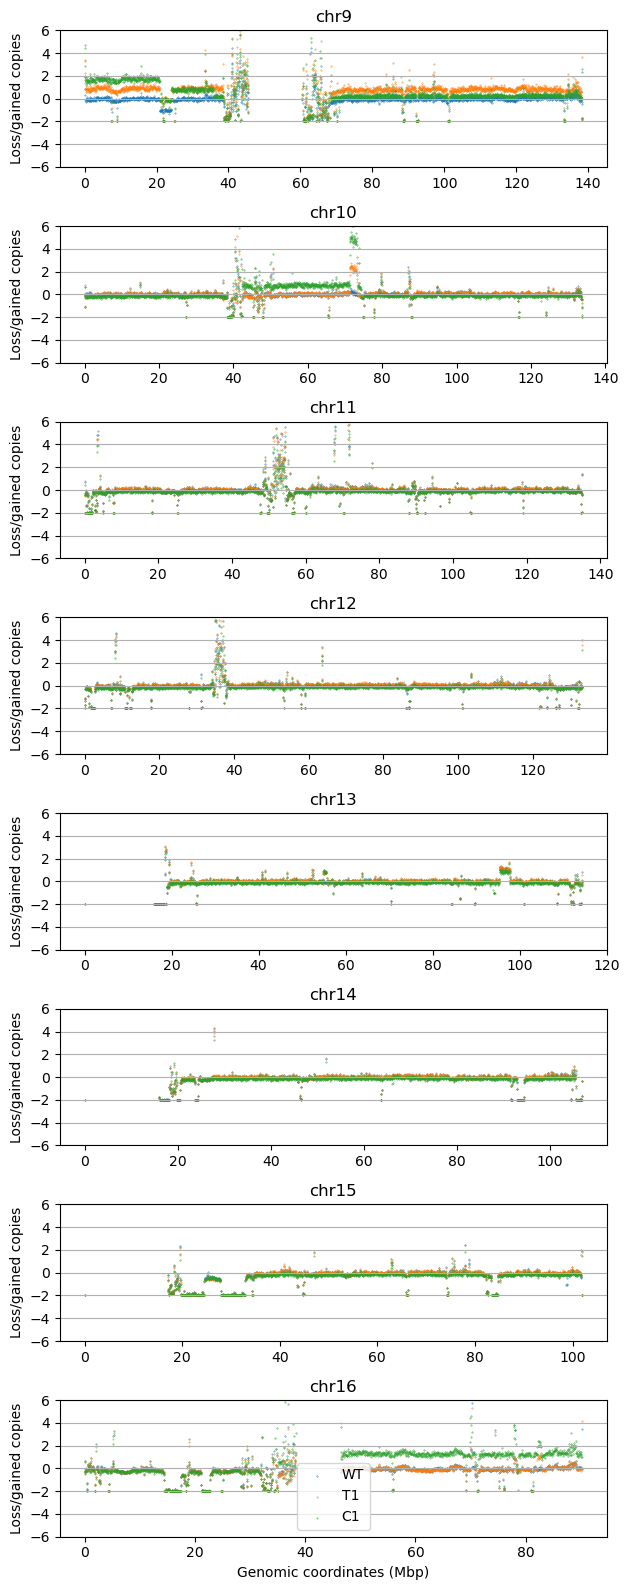

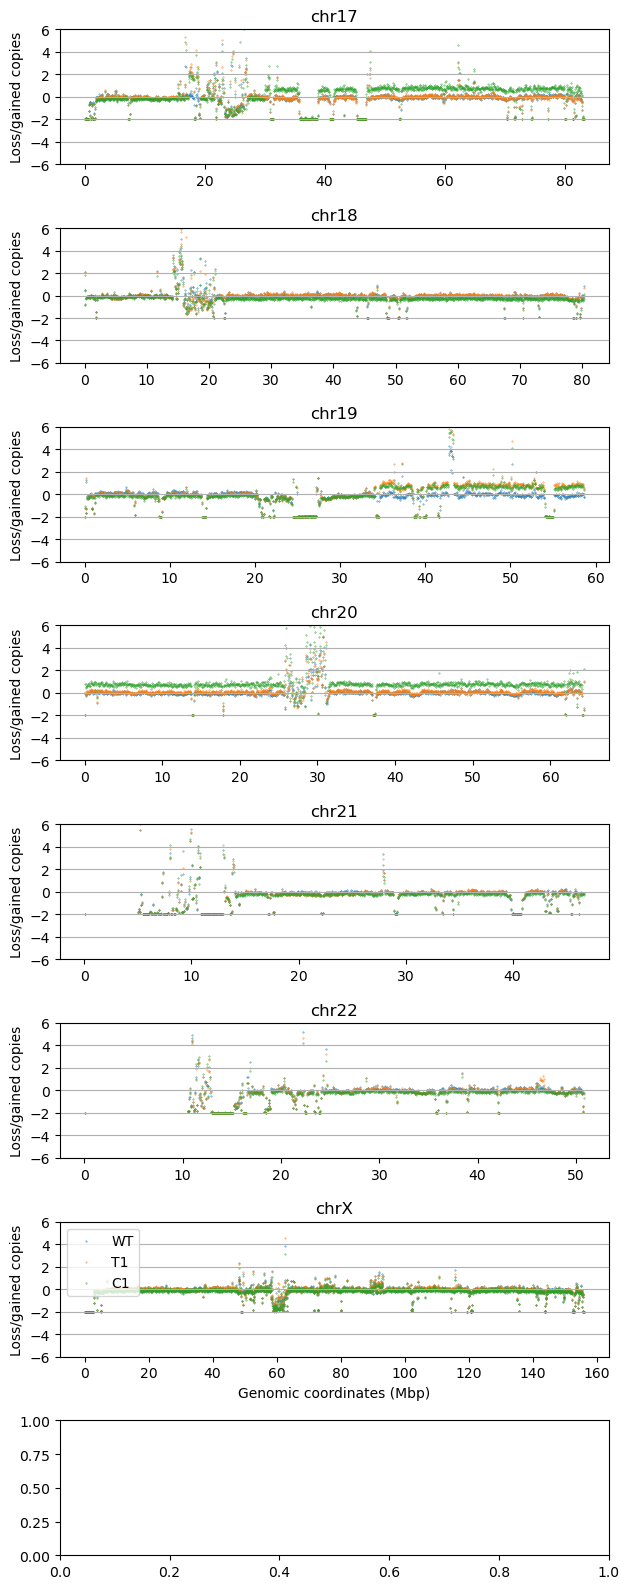

In [5]:
batch_size = 8
num_chroms = list(dfs.values())[0]["chrom"].nunique()
cols = int(math.ceil(num_chroms / batch_size))
rows = batch_size

figs = []
axs_flat = []

for i in range(cols):
    fig, axs = plt.subplots(rows, 1, figsize=(6.4, 2 * rows))
    figs.append(fig)
    axs_flat.extend(axs)

for sample, df in dfs.items():
    for ax, (key, dff) in zip(axs_flat, df.groupby("chrom", sort=False)):
        ax.scatter((dff["start"] + dff["end"]) / (2 * 1.0e6), dff["obs"], s=0.1, label=sample)
        ax.set(title=key, ylim=(-6, 6), ylabel="Loss/gained copies")
        ax.grid(axis="y")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        if key in ["chr8", "chr16", "chrX"]:
            ax.set(xlabel="Genomic coordinates (Mbp)")
            ax.legend()

for i, fig in enumerate(figs):
    fig.tight_layout()
    fig.savefig(f"/tmp/mcf10a_cnvs_{i}.svg")